Notebook for testing the TETRAQUAD module

In [1]:
# Initialise

import tetraquad
import numpy as np
import matplotlib.pyplot as plt


# Some useful functions
def get_poly(p, q, r):
    return lambda k1, k2, k3: tetraquad.poly_evaluations(p, q, r, k1, k2, k3)

def get_sine(omega, phi):
    return lambda k1, k2, k3: tetraquad.sine_evaluations(omega, phi, k1, k2, k3)


# Matplotlib plot settings
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "font.size": 10,
    "text.usetex": True,
    "axes.labelsize": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.dpi": 300,
    "savefig.bbox": "tight"
})
fig_width = 510 / 72.27
fig_height = fig_width / 1.61803

In [3]:
# Compute or load some quadrature rules

alpha = 0.001
N = 30
negative_power = 0.96 - 2

grid, weights = tetraquad.unit_quadrature_nnls(alpha, N)
#grid, weights = tetraquad.load_quadrature(f"outputs/tetraquad_alpha_N_{N}.csv")

N = 10
#grid, weights = tetraquad.unit_quadrature_nnls(alpha, N)
grid_neg, weights_neg = tetraquad.load_quadrature(f"outputs/tetraquad_alpha_negative_power_N_{N}.csv")

#grid_uni, weights_uni = tetraquad.uniform_tetrapyd_weights(alpha, N, MC_N_SAMPLES=100000, include_endpoints=False)
grid_uni, weights_uni = tetraquad.load_quadrature(f"outputs/uniform_quad_alpha_N_{N}.csv")

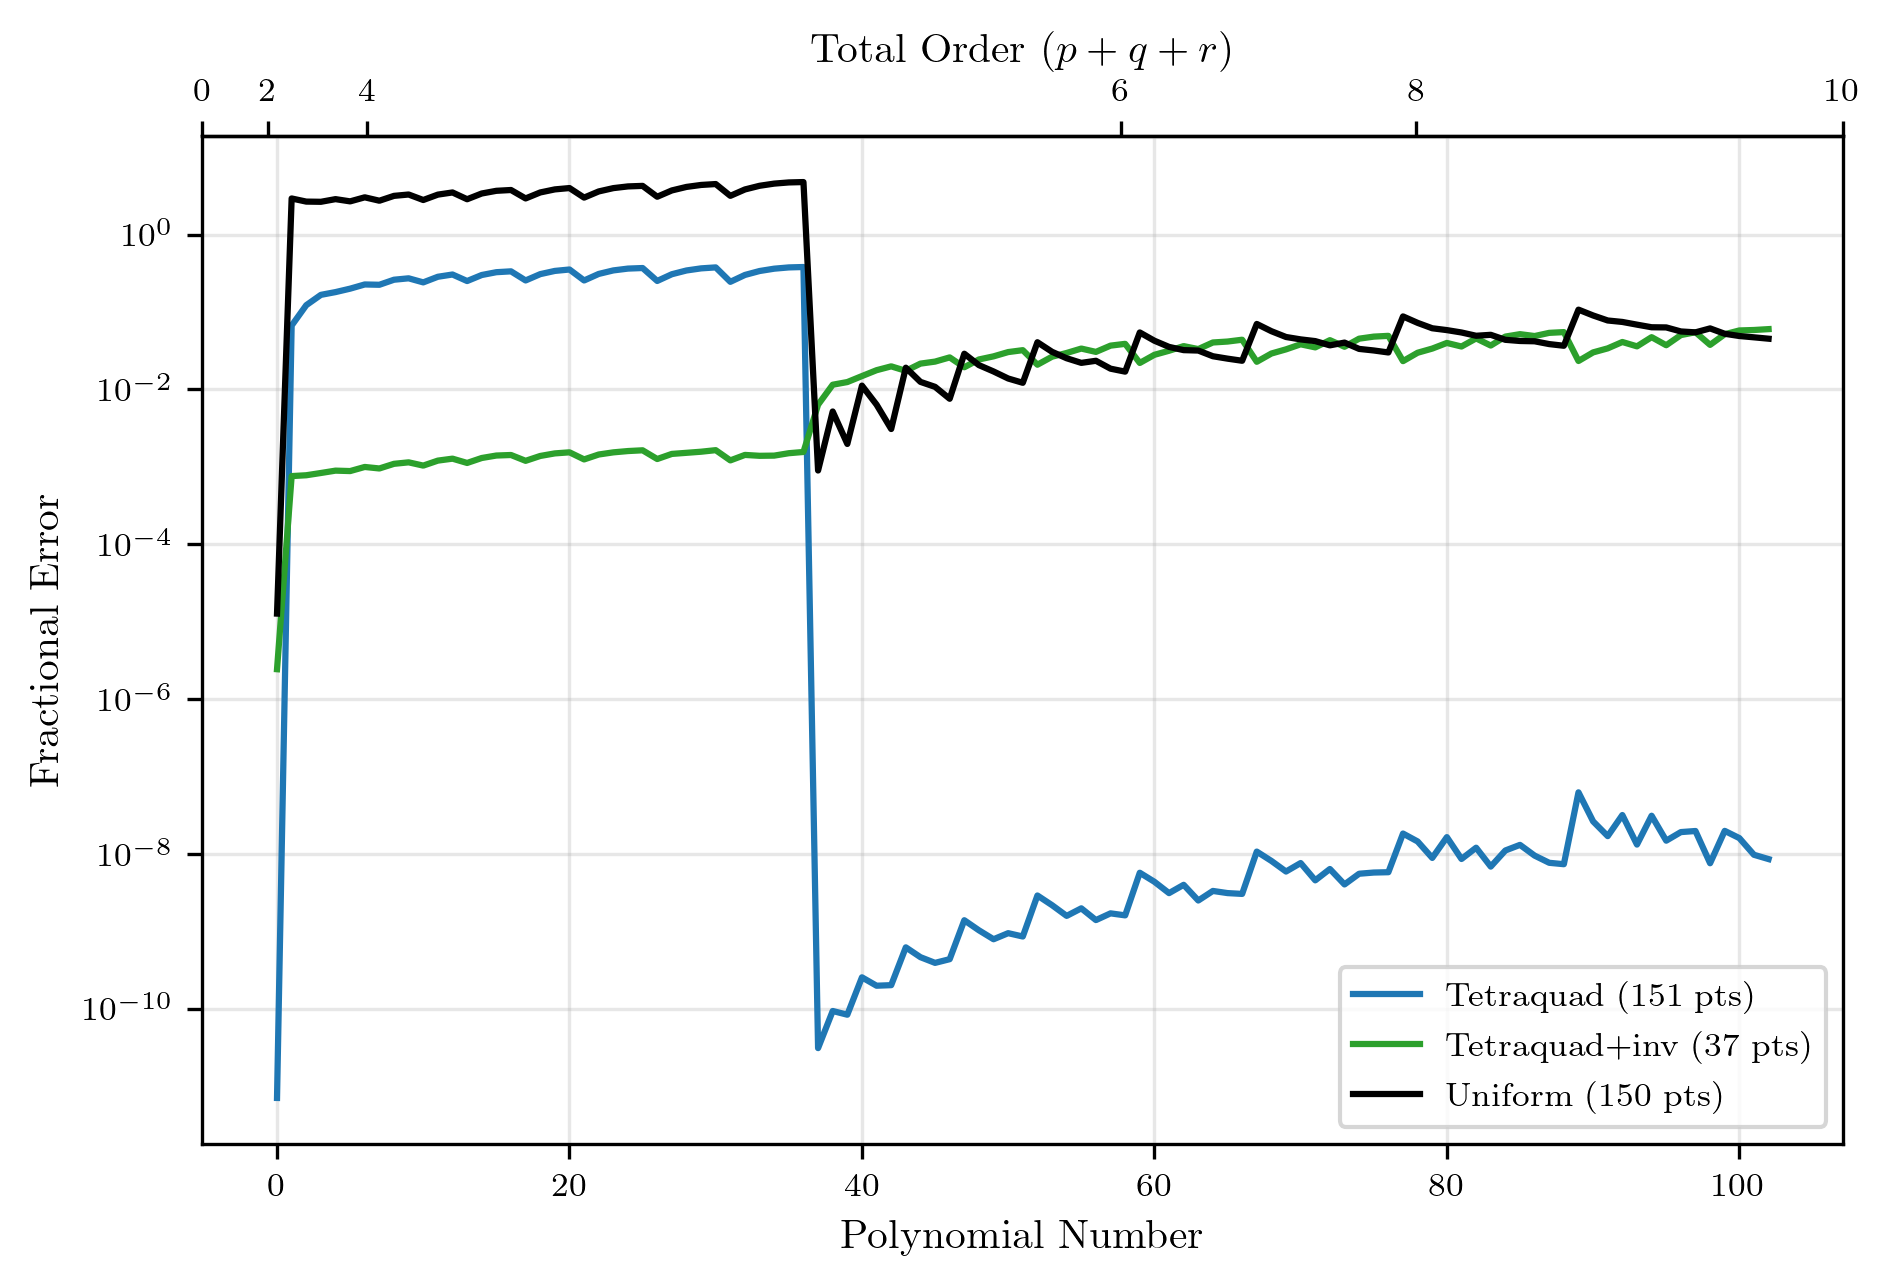

In [4]:
# Test to check numerical integration accuracy

k1, k2, k3 = grid
#ps, qs, rs = tetraquad.poly_triplets_total_degree(3*N)
ps, qs, rs = tetraquad.poly_triplets_total_degree(N, negative_power=-2+0.965)

analytic = tetraquad.analytic_poly_integrals_alpha(ps, qs, rs, alpha)

numerical = np.array([np.dot(weights, tetraquad.poly_evaluations(p, q, r, k1, k2, k3)) for p, q, r in zip(ps, qs, rs)])
numerical_neg = np.array([np.dot(weights_neg, tetraquad.poly_evaluations(p, q, r, grid_neg[0,:], grid_neg[1,:], grid_neg[2,:])) for p, q, r in zip(ps, qs, rs)])
numerical_uni = np.array([np.dot(weights_uni, tetraquad.poly_evaluations(p, q, r, grid_uni[0,:], grid_uni[1,:], grid_uni[2,:])) for p, q, r in zip(ps, qs, rs)])

error = np.abs((numerical - analytic) / analytic)
error_neg = np.abs((numerical_neg - analytic) / analytic)
error_uni = np.abs((numerical_uni - analytic) / analytic)

tot_degree = ps + qs + rs
poly_number = np.arange(len(tot_degree))


# Helper functions for the plot
def forward(x):
    return np.interp(x, poly_number, tot_degree)
def inverse(y):
    return np.interp(y, tot_degree, poly_number)

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.plot(error, label="Tetraquad ({} pts)".format(grid.shape[1]), c="tab:blue")
ax.plot(error_neg, label="Tetraquad+inv ({} pts)".format(grid_neg.shape[1]), c="tab:green")
ax.plot(error_uni, label="Uniform ({} pts)".format(grid_uni.shape[1]), c="k")
ax.set_xlabel("Polynomial Number")
ax.set_yscale('log')
ax.set_ylabel("Fractional Error")
secax = ax.secondary_xaxis("top", functions=(forward,inverse))
secax.set_xlabel("Total Order $(p+q+r)$")
ax.legend(loc="lower right")
#ax.text(2300, 2e-8, rf"$I(p,q,r) = \int dV \; k_1^p k_2^q k_3^r$")
ax.grid(True, alpha=0.3)

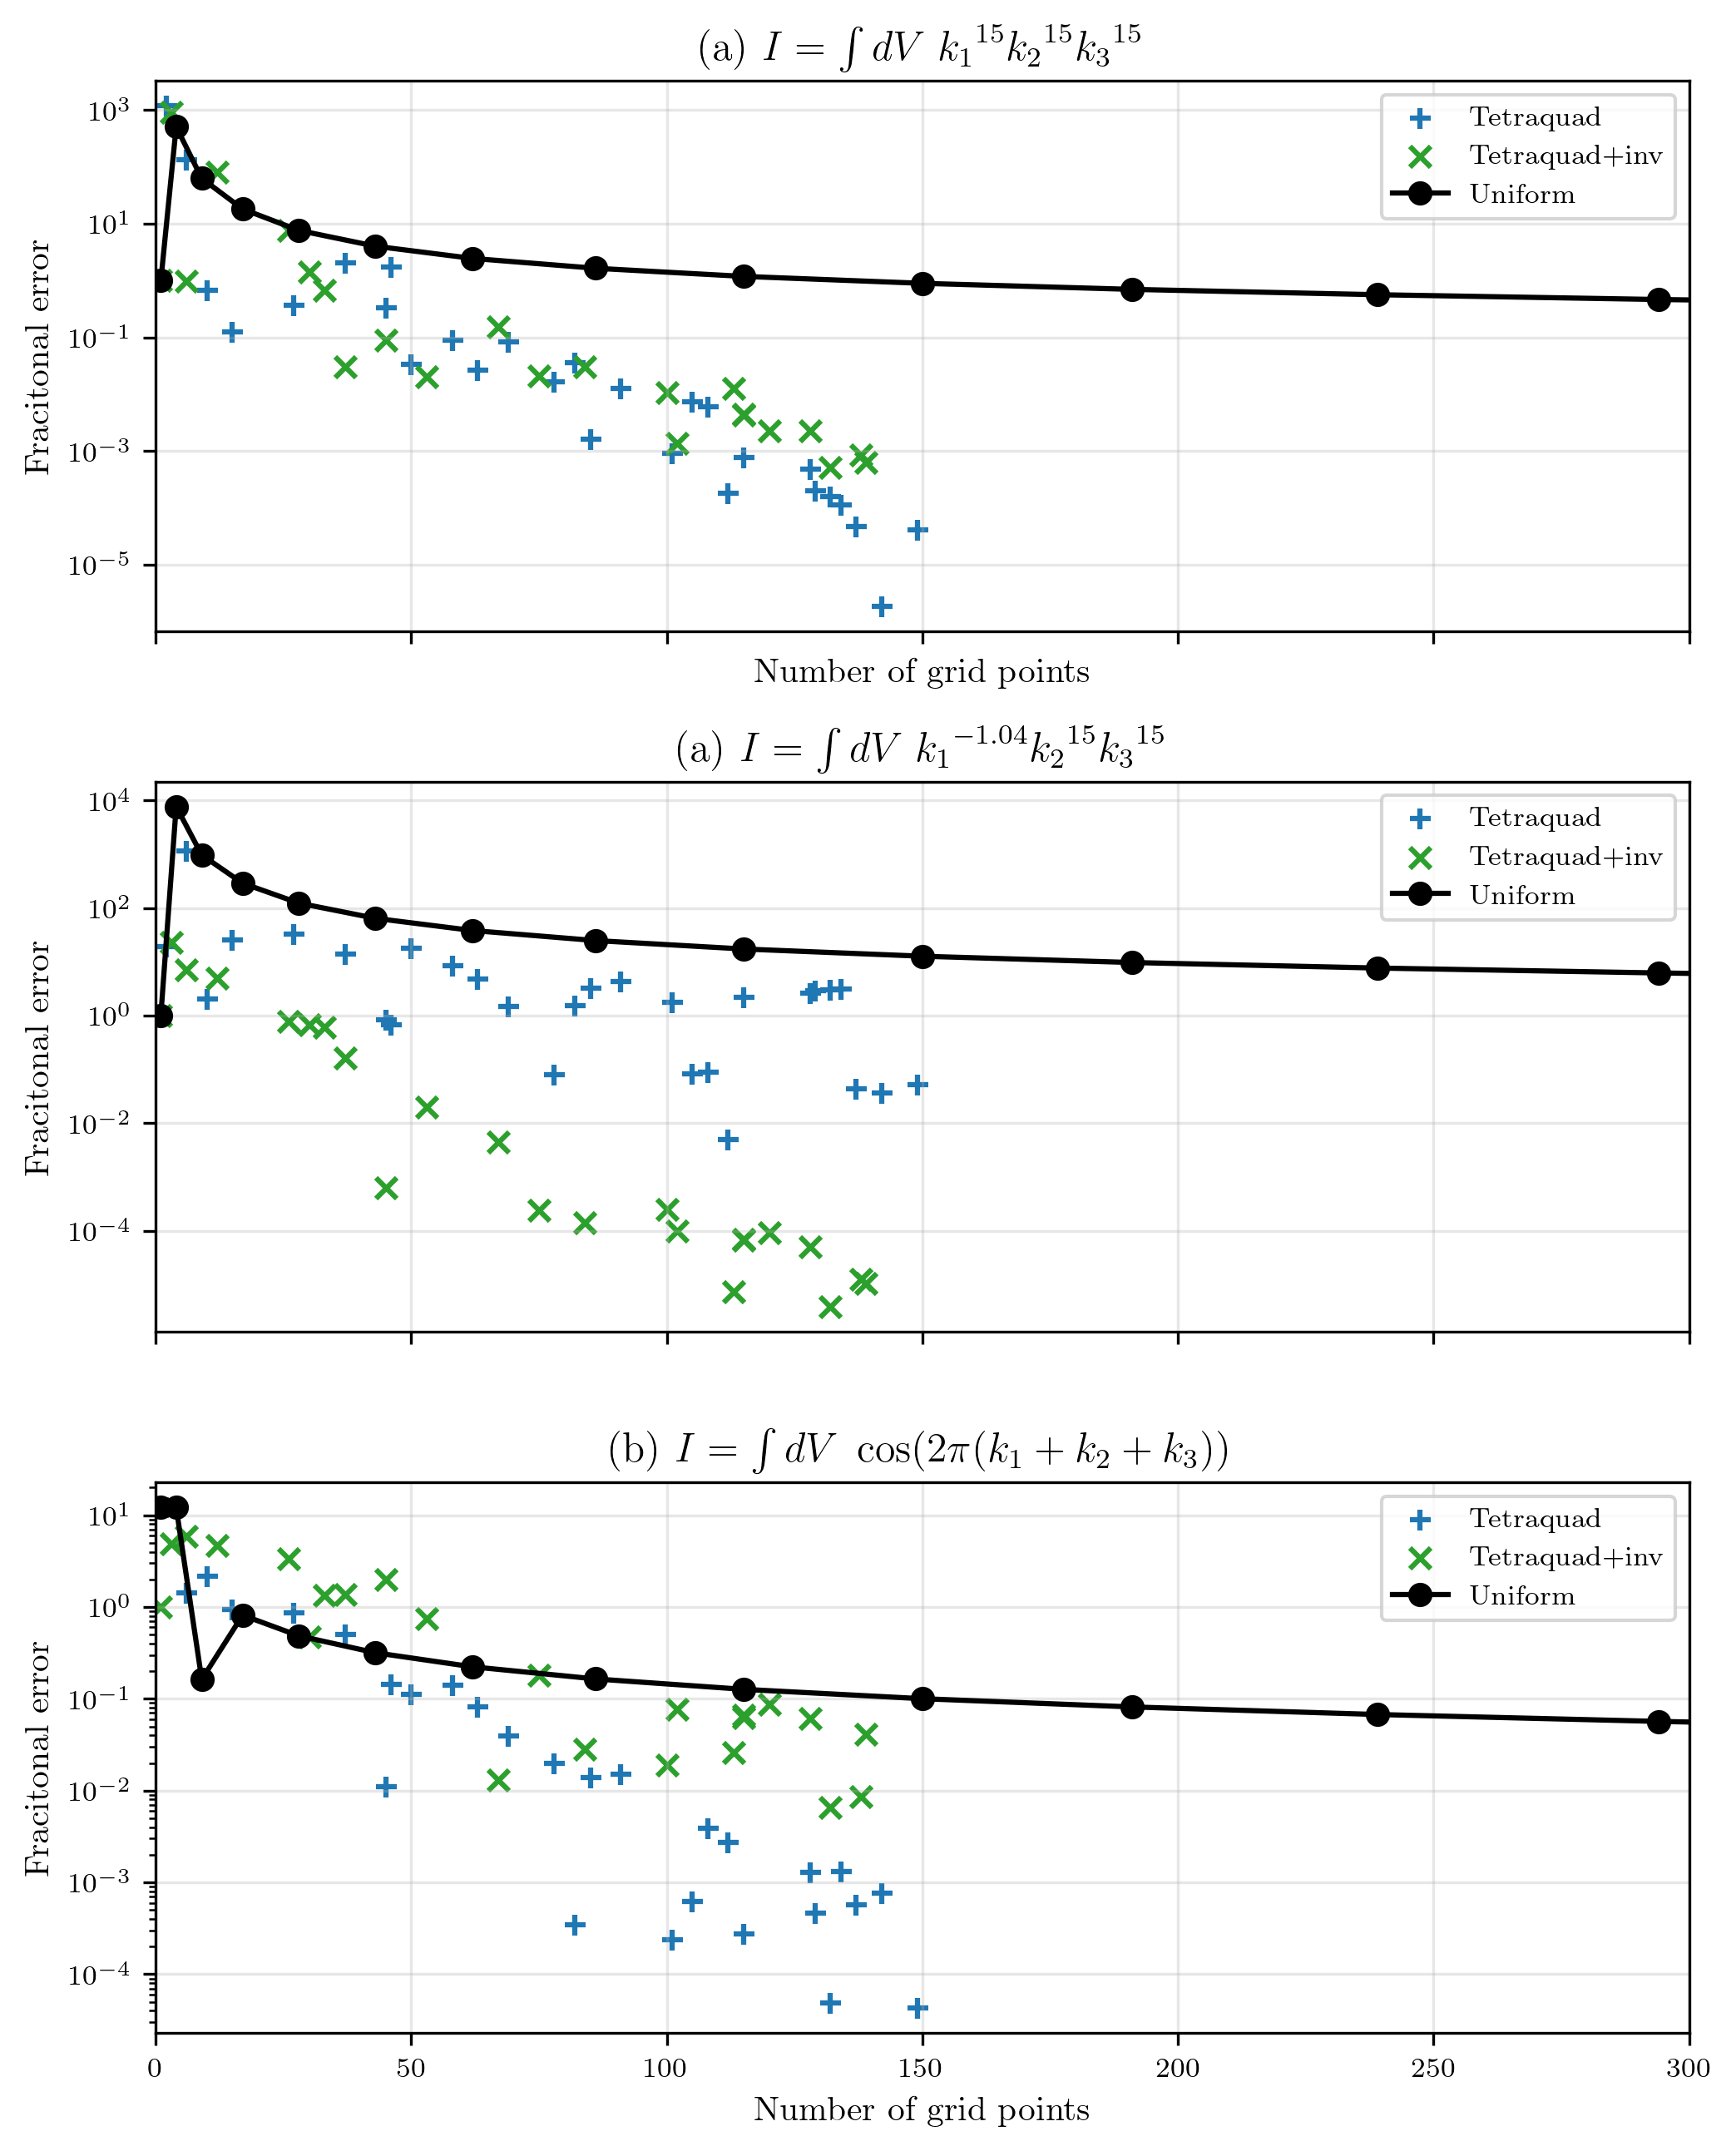

In [4]:
# Test the accuracy of quadrature with different sizes

alpha = 0.001

Ns = np.arange(1, 30)

# Test polynomials
#pqrs = [(5, 5, 5), (10, 10, 10), (15, 15, 15)]
pqrs = [(15, 15, 15), (-1.04, 15, 15)]
test_funcs = [get_poly(p, q, r) for p, q, r in pqrs]
test_ans = [tetraquad.analytic_poly_integrals_alpha(np.array([p]), np.array([q]), np.array([r]), alpha) for p, q, r in pqrs]
#labels = [fr"$I = \int dV \; {{k_1}}^{{{p}}} {{k_2}}^{{{q}}} {{k_3}}^{{{r}}}$" for p, q, r in pqrs]
labels = [fr"(a) $I = \int dV \; {{k_1}}^{{{p}}} {{k_2}}^{{{q}}} {{k_3}}^{{{r}}}$" for p, q, r in pqrs]

# Test sinusoidals
#omegas = [2*np.pi/2, 2*np.pi, 2*np.pi*2]
omegas = [2*np.pi]
test_funcs = test_funcs + [get_sine(omega, np.pi/2) for omega in omegas]
test_ans = test_ans + [tetraquad.analytic_sine_integrals(omega, np.pi/2, alpha) for omega in omegas]
#labels = labels + [fr"$\int dV \; \cos({omega:.3f}(k_1 + k_2 + k_3))$" for omega in omegas]
labels = labels + [fr"(b) $I = \int dV \; \cos(2\pi(k_1 + k_2 + k_3))$" for omega in omegas]

tetra = dict()
tetra_sizes = dict()
tetra_neg = dict()
tetra_neg_sizes = dict()
uni = dict()
uni_sizes = dict()

for N in Ns:
    grid, weights = tetraquad.load_quadrature("outputs/tetraquad_alpha_N_{}.csv".format(N))
    k1, k2, k3 = grid
    tetra[N] = [np.dot(weights, func(k1, k2, k3)) for func in test_funcs]
    tetra_sizes[N] = len(weights)

    try:
        grid, weights = tetraquad.load_quadrature("outputs/tetraquad_alpha_negative_power_N_{}.csv".format(N))
        k1, k2, k3 = grid
        tetra_neg[N] = [np.dot(weights, func(k1, k2, k3)) for func in test_funcs]
        tetra_neg_sizes[N] = len(weights)
    except:
        pass

    grid, weights = tetraquad.load_quadrature("outputs/uniform_quad_alpha_N_{}.csv".format(N))
    k1, k2, k3 = grid
    uni[N] = [np.dot(weights, func(k1, k2, k3)) for func in test_funcs]
    uni_sizes[N] = len(weights)

# Plot the results
#fig, axs = plt.subplots(3, 2, figsize=(fig_width*2, fig_height*3), sharex=True)
fig, axs = plt.subplots(3, 1, figsize=(fig_width*1, fig_height*2), sharex=True)
axs = axs.T.reshape(-1)

for i in range(len(test_funcs)):
    true_val = test_ans[i]
    tetra_x = [tetra_sizes[N] for N in Ns]
    tetra_y = [np.abs((tetra[N][i]-true_val)/true_val) for N in Ns]

    tetra_neg_x = [tetra_neg_sizes[N] for N in Ns if N in tetra_neg.keys()]
    tetra_neg_y = [np.abs((tetra_neg[N][i]-true_val)/true_val) for N in Ns if N in tetra_neg.keys()]

    uni_x = [uni_sizes[N] for N in Ns]
    uni_y = [np.abs((uni[N][i]-true_val)/true_val) for N in Ns]

    axs[i].scatter(tetra_x, tetra_y, marker="+", c="tab:blue", label="Tetraquad")
    axs[i].scatter(tetra_neg_x, tetra_neg_y, marker="x", c="tab:green", label="Tetraquad+inv")
    #axs[i].scatter(uni_x, uni_y, label="Uniform")
    axs[i].plot(uni_x, uni_y, "-o", c="k", label="Uniform")
    axs[i].set_ylabel("Fracitonal error")
    axs[i].set_yscale("log")
    axs[i].legend()
    axs[i].set_xlim([0, 300])
    axs[i].set_title(labels[i])
    axs[i].grid(True, alpha=0.3)

axs[len(axs)//2-1].set_xlabel("Number of grid points")
axs[-1].set_xlabel("Number of grid points")
fig.tight_layout()

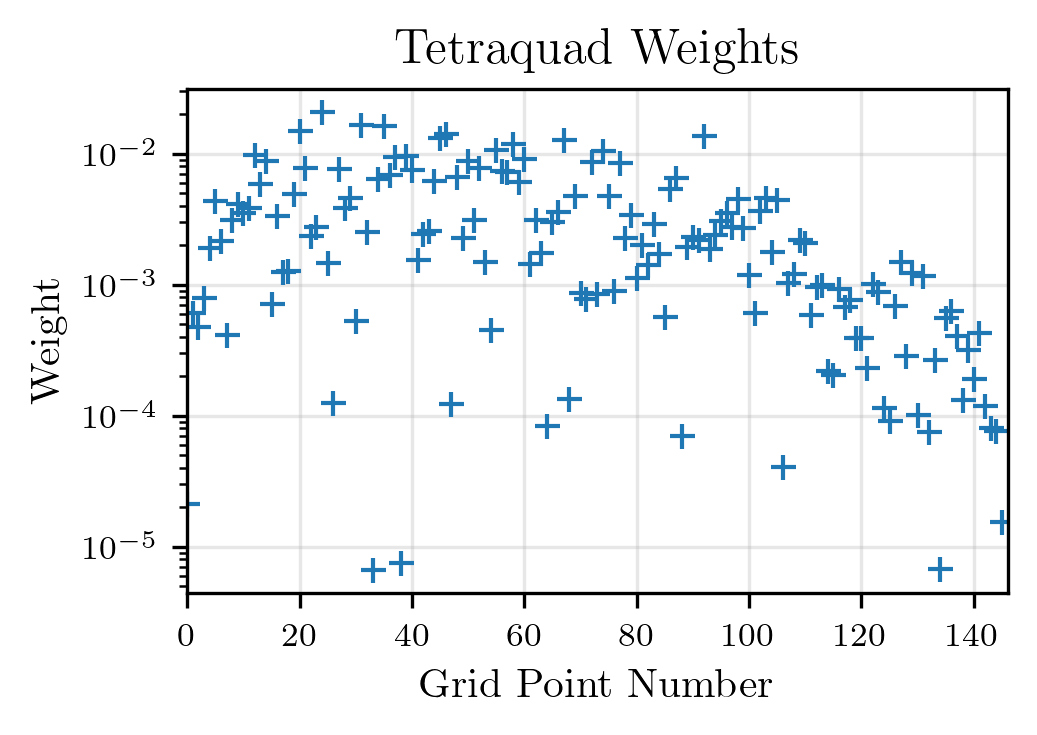

In [9]:
N = 30
grid, weights = tetraquad.load_quadrature(f"outputs/tetraquad_alpha_N_{N}.csv")
#grid, weights = tetraquad.load_quadrature(f"outputs/tetraquad_alpha_negative_power_N_{N}.csv")

plt.figure(figsize=(fig_width/2, fig_height/2))
plt.plot(weights, "+", c="tab:blue")
plt.yscale("log")
plt.xlabel("Grid Point Number")
plt.xlim(0, len(weights))
plt.ylabel("Weight")
plt.title("Tetraquad Weights")
plt.grid(True, alpha=0.3)

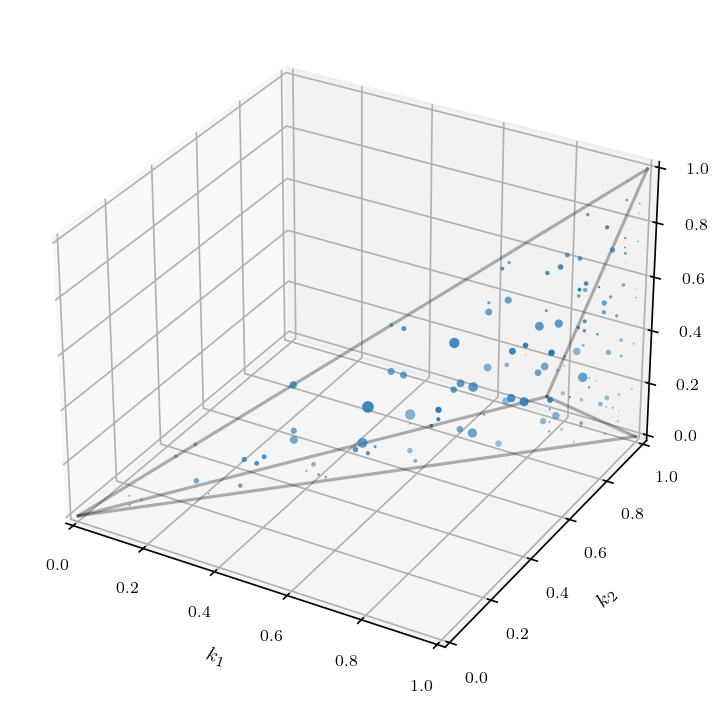

In [10]:
s = weights * 1500
v = np.linspace(alpha, 1, 1000)
va = alpha * np.ones_like(v)
vo = np.ones_like(v)
xs, ys, zs = grid
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs, ys, zs, s=s, c="tab:blue", lw=0)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])
ax.set_xlabel(r"$k_1$")
ax.set_ylabel(r"$k_2$")
ax.set_zlabel(r"$k_3$")
ax.plot(v, v, v, c="k", alpha=0.3)
ax.plot(v, v, va, c="k", alpha=0.3)
ax.plot(vo[500:], v[500:], v[500:], c="k", alpha=0.3)
ax.plot(vo[500:], v[500:], 1-v[500:], c="k", alpha=0.3)
ax.plot(v, v/2, v/2, c="k", alpha=0.3)
ax.plot(vo, vo, va, c="k", alpha=0.3)
#ax.set_title("Tetraquad Weights")
fig.tight_layout()

(array([21.,  9.,  9.,  7.,  9.,  5.,  5.,  3.,  3.,  5.,  5.,  4.,  2.,
         4.,  5.,  0.,  4.,  2.,  2.,  1.,  1.,  3.,  3.,  1.,  0.,  1.,
         0.,  0.,  1.,  2.,  1.,  2.,  1.,  0.,  1.,  1.,  2.,  2.,  0.,
         0.,  1.,  2.,  1.,  1.,  0.,  2.,  1.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([6.66467040e-06, 2.14730620e-04, 4.22796570e-04, 6.30862520e-04,
        8.38928469e-04, 1.04699442e-03, 1.25506037e-03, 1.46312632e-03,
        1.67119227e-03, 1.87925822e-03, 2.08732417e-03, 2.29539012e-03,
        2.50345607e-03, 2.71152202e-03, 2.91958797e-03, 3.12765392e-03,
        3.33571987e-03, 3.54378582e-03, 3.75185177e-03, 3.95991771e-03,
        4.16798366e-03, 4.37604961e-03, 4.58411556e-03, 4.79218151e-03,
  

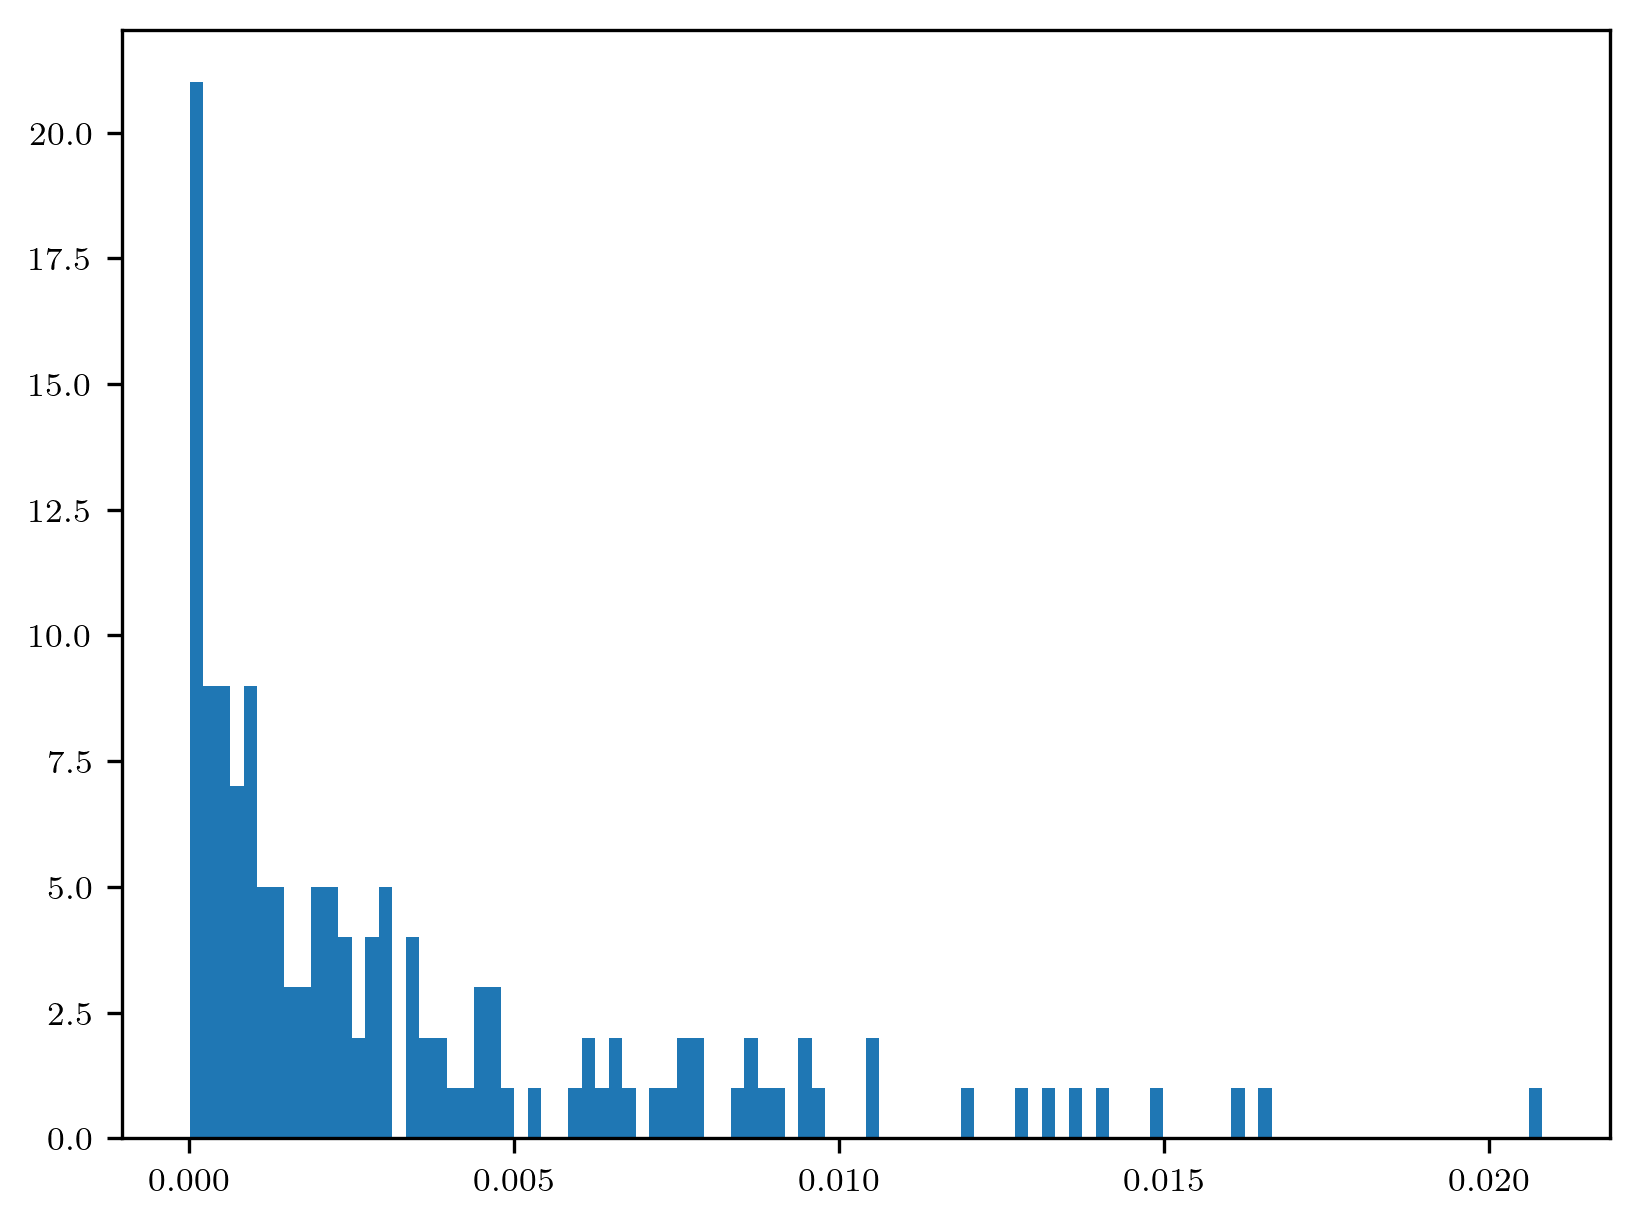

In [11]:
#weights.flatten()
plt.hist(weights, bins=100)